In [1]:
import os
import datetime

import IPython
import IPython.display

import pandas as pd
import seaborn as sns
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from tqdm import tqdm

In [103]:
def wind_vector(self, velocity, max_velocity, direction):
    # Convert to radians.
    wd_rad = direction*np.pi / 180
    self['Wx'] = velocity*np.cos(wd_rad)
    self['Wy'] = velocity*np.sin(wd_rad)
    self['max Wx'] = max_velocity*np.cos(wd_rad)
    self['max Wy'] = max_velocity*np.sin(wd_rad)
pd.DataFrame.wind_vector = wind_vector

In [104]:
def tod_signal(self, date_time):
    day = 24*60*60
    year = (365.2425)*day
    timestamp_s = date_time.map(datetime.datetime.timestamp)
    self['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    self['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    self['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    self['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
pd.DataFrame.tod_signal = tod_signal

In [15]:
# Training set from history file
df = pd.read_csv('vantaa-2017-2020.csv.gz', compression='gzip')
df['time'] = pd.to_datetime(df[['Pv','Kk','Vuosi', 'Klo']]
                   .astype(str).apply(' '.join, 1), format='%d %m %Y %H:%M')
df.drop(columns=['Pv','Kk','Vuosi', 'Klo', 'Aikavyöhyke'], inplace=True)
df.index = df['time']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 213965 entries, 2017-01-01 00:00:00 to 2021-02-09 00:00:00
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Ilmanpaine (msl) (hPa)    212924 non-null  float64       
 1   Suhteellinen kosteus (%)  212917 non-null  float64       
 2   Ilman lämpötila (degC)    212913 non-null  float64       
 3   Tuulen suunta (deg)       212272 non-null  float64       
 4   Puuskanopeus (m/s)        212264 non-null  float64       
 5   Tuulen nopeus (m/s)       212248 non-null  float64       
 6   time                      213965 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 13.1 MB


In [16]:
interpo = df.resample('600s').mean().interpolate()
#interpo = interpo[5::6]
interpo.head(2)

,Ilmanpaine (msl) (hPa),Suhteellinen kosteus (%),Ilman lämpötila (degC),Tuulen suunta (deg),Puuskanopeus (m/s),Tuulen nopeus (m/s)
time,,,,,,
2017-01-01 00:00:00,998.1,87.0,3.3,277.0,8.3,6.2
2017-01-01 00:10:00,998.2,87.0,3.1,273.0,7.4,5.3


In [17]:
wind_direction = interpo['Tuulen suunta (deg)']
wind_v = interpo['Tuulen nopeus (m/s)']
wind_v_max = interpo['Puuskanopeus (m/s)']

Text(0, 0.5, 'Wind Velocity [m/s]')

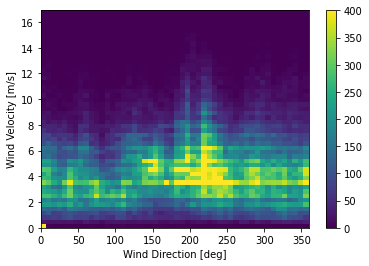

In [18]:
plt.hist2d(wind_direction, wind_v, bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

In [19]:
# Convert to wind vector
interpo.wind_vector(interpo.pop('Tuulen nopeus (m/s)'), interpo.pop('Puuskanopeus (m/s)'), interpo.pop('Tuulen suunta (deg)'))


(-16.07285512538809, 13.3882665834825, -14.030928932907388, 12.718853254308373)

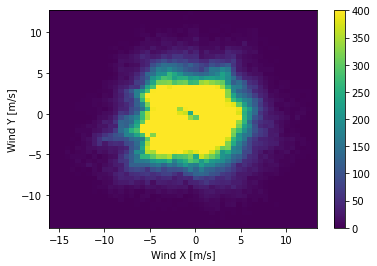

In [20]:
plt.hist2d(interpo['Wx'], interpo['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

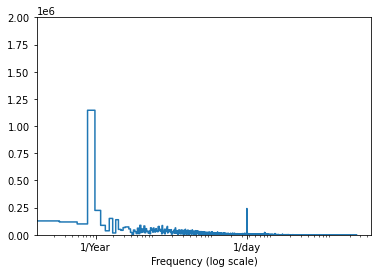

In [21]:
# look for seasonality although we know that year and day will be important features for weather data
fft = tf.signal.rfft(interpo['Ilman lämpötila (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(interpo['Ilman lämpötila (degC)'])
samples_per_year = 6*24*365.2524 # 10m sampling rate
years_per_dataset = n_samples_h/(samples_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 2000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [22]:
# calculate time of day signal from time index
interpo.tod_signal(interpo.index.get_level_values('time'))

Text(0.5, 1.0, 'Time of day signal')

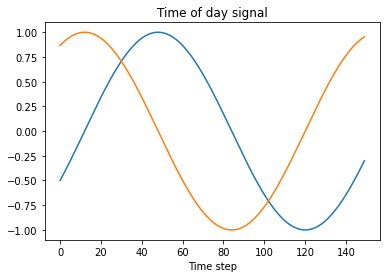

In [23]:
plt.plot(np.array(interpo['Day sin'])[:25*6])
plt.plot(np.array(interpo['Day cos'])[:25*6])
plt.xlabel('Time step')
plt.title('Time of day signal')

In [24]:
# Split dataset
column_indices = {name: i for i, name in enumerate(interpo.columns)}

n = len(interpo)
train_df = interpo[0:int(n*0.7)]
val_df = interpo[int(n*0.7):int(n*0.9)]
test_df = interpo[int(n*0.9):]

num_features = interpo.shape[1]

In [26]:
# Normalize
train_mean = train_df.mean()
train_std = train_df.std()
train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [123]:
# store values used for normalization so that we can use them on predicitions
train_mean.to_pickle('predict/train_mean.pkl')
train_std.to_pickle('predict/train_std.pkl')
pd.DataFrame(train_df.columns).to_csv('predict/trainset_columns.csv')

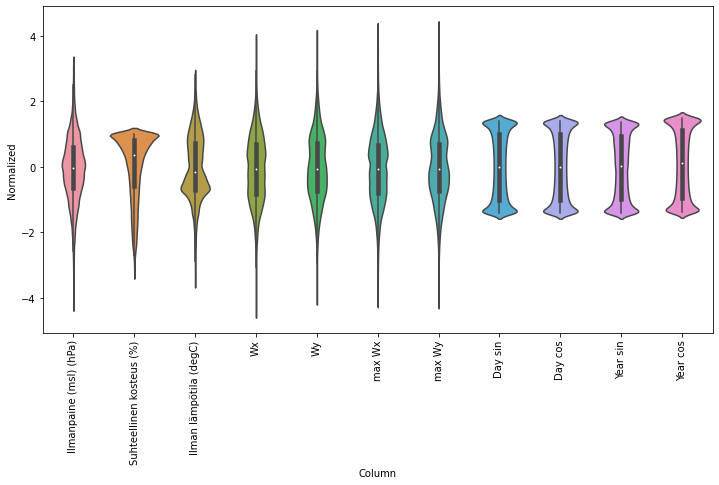

In [29]:
df_std = (interpo - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(interpo.keys(), rotation=90)

In [30]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [31]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [32]:
def plot(self, model=None, plot_col='Ilman lämpötila (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time steps')

WindowGenerator.plot = plot

In [33]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [34]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [35]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [36]:
# Now that we have defined the functions let's try multi step models to predict next 24h using on 24h history
val_performance = {}
performance = {}

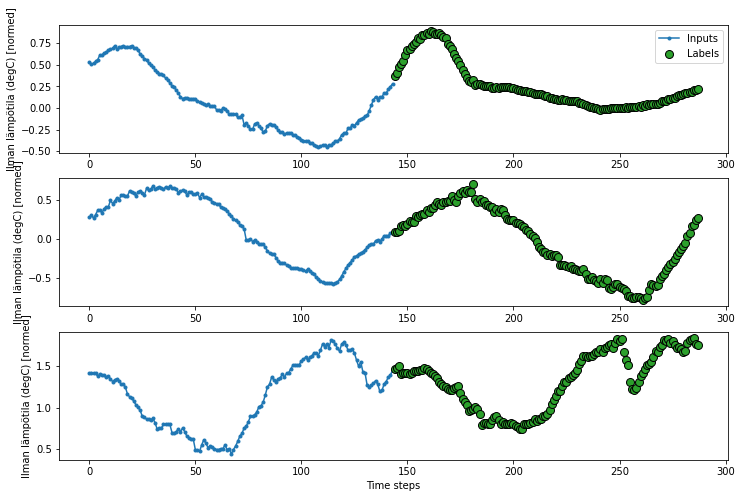

In [37]:
OUT_STEPS = 6*24
multi_window = WindowGenerator(input_width=6*24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()

1342/1342 [==============================] - 2s 1ms/step - loss: 0.7914 - mean_absolute_error: 0.5721


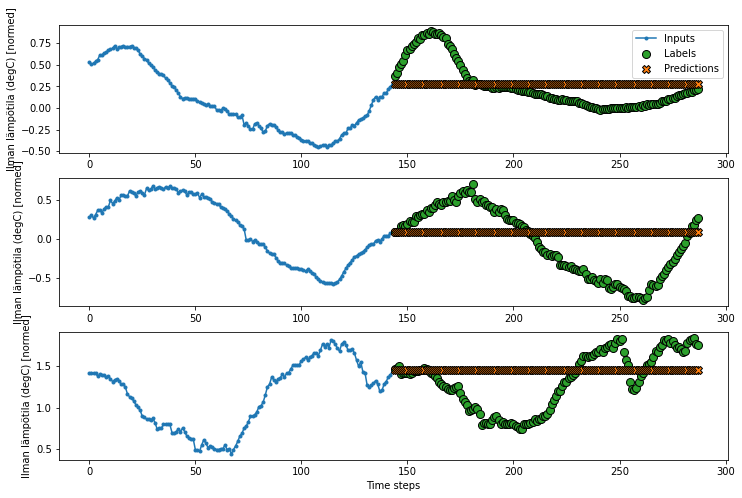

In [38]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

1342/1342 [==============================] - 1s 1ms/step - loss: 0.6040 - mean_absolute_error: 0.4450


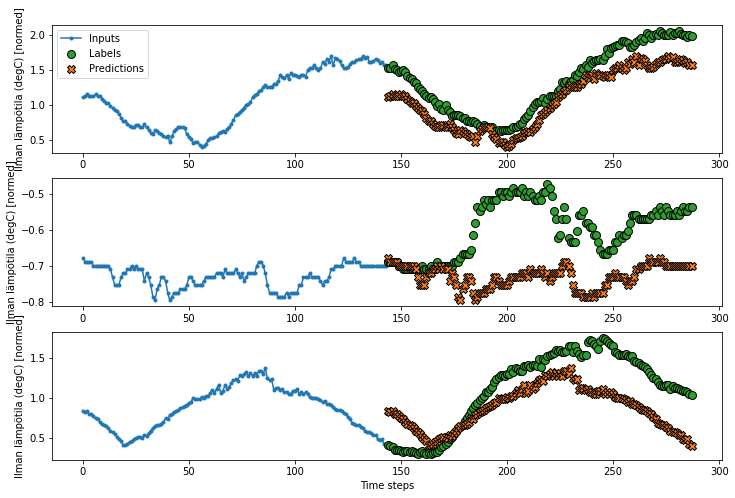

In [42]:
# this baseline repeats the previous day assuming tomorrow is same as today
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

1342/1342 [==============================] - 2s 1ms/step - loss: 0.2947 - mean_absolute_error: 0.3105


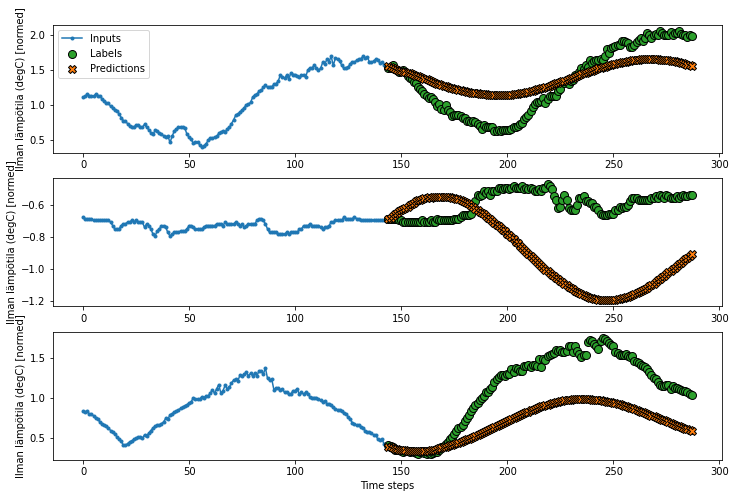

In [43]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

1342/1342 [==============================] - 14s 11ms/step - loss: 0.3896 - mean_absolute_error: 0.3558


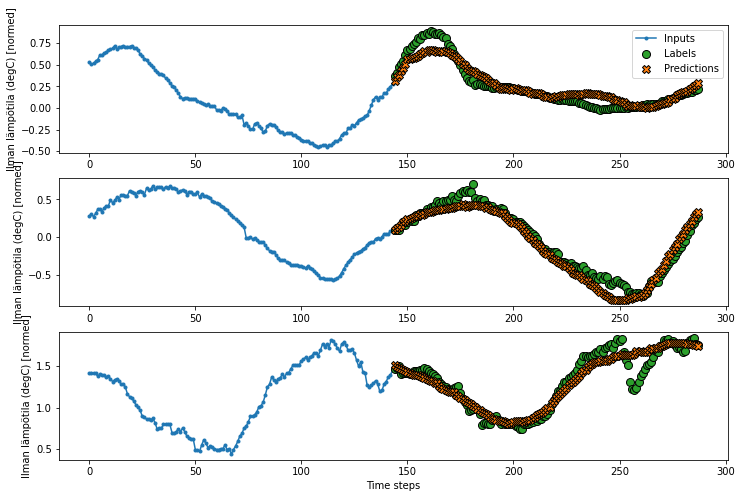

In [52]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(1024, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features),
                          #kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [53]:
multi_lstm_model.save('multi_lstm')

INFO:tensorflow:Assets written to: multi_lstm/assets


INFO:tensorflow:Assets written to: multi_lstm/assets


In [41]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [42]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [43]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [44]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 11])

In [45]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

1342/1342 [==============================] - 30s 22ms/step - loss: 0.7455 - mean_absolute_error: 0.6815


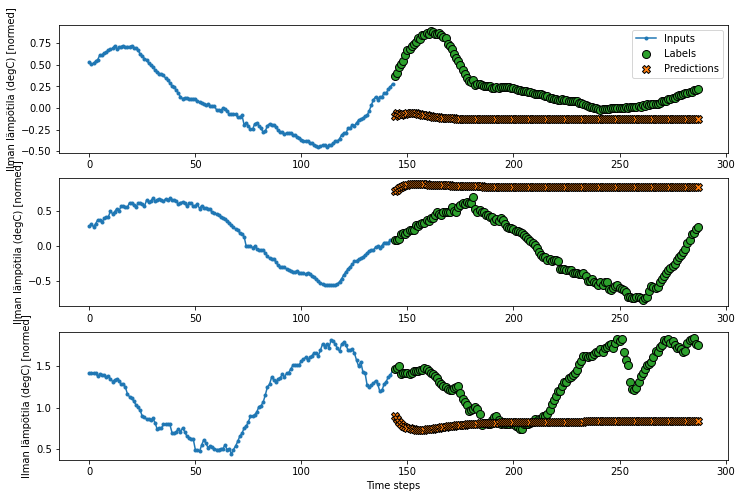

In [46]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

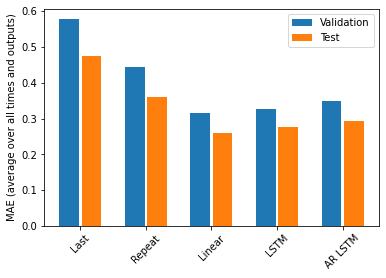

In [178]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()